In [1]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
hbar = c.hbar
KB = c.Boltzmann

In [3]:
col = ['T','1/Q','1/Q_err','T_err']
data = pd.read_csv('data_20_02_set2.txt',delimiter='\t',usecols=col)

Let's look at the first resonance at different temperatures

In [4]:
indx = [i for (i,y) in enumerate(data['1/Q']) if (i%4==0)]
x = np.array(data['T'][indx])*1e-3
y = np.array(data['1/Q'][indx])
yerr = np.array(data['1/Q_err'][indx])
xerr = np.array(data['T_err'][indx])*1e-3

Now data are unordered\
We have to order them by temperature T

In [5]:
sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
x = np.array([x[i] for i in sorted_indices])
y = np.array([y[i] for i in sorted_indices])
xerr = xerr[sorted_indices]
yerr = yerr[sorted_indices]

In [6]:
indices = [i for (i,y) in enumerate(y) if (y>0 and y<1 and x[i]!=50)]
x = np.array([x[i] for i in indices])
y = np.array([y[i] for i in indices])
xerr = xerr[indices]
yerr = yerr[indices]                                   

In [7]:
indices = [i for (i,x) in enumerate(x) if (x!=0.050)]
x = np.array([x[i] for i in indices])
y = np.array([y[i] for i in indices])
xerr = xerr[indices]
yerr = yerr[indices]

Now that we have selected data (I think we hav eto justify the choises we made) we can plot them

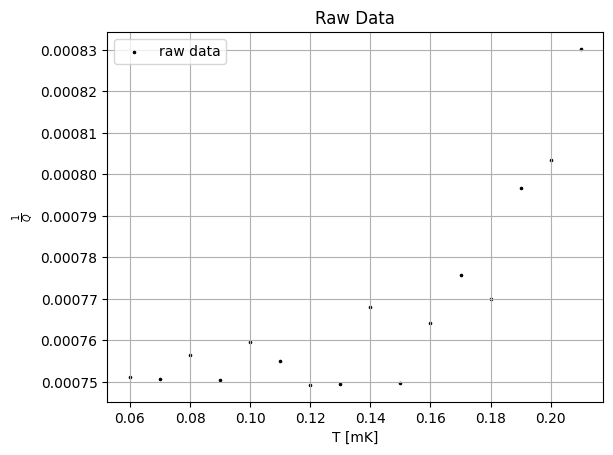

In [8]:
plt.scatter(x, y, s=10, marker='.', color='black', label='raw data')
plt.xlabel('T [mK]')
plt.ylabel(r'$\frac{1}{Q}$')
plt.legend()
plt.title('Raw Data')
plt.grid()

Let's estimate at the parameter $Q_{0}$

In [9]:
q0 = np.mean(y[np.where(x<0.12)[0]])
b = 1e-7
T_k = 14*1e-3
alpha = 0.8367

In [10]:
def QT(T,d0):
    omega = 5*1e9
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + q0

def kondo(T,d0, b, T_k):
    omega = 5*1e11
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + q0 - b*np.log(T/T_k)

Let's plot data and compare them with analytical models provided the forecasted parameters

In [11]:
d0 = 1.65*1e-23

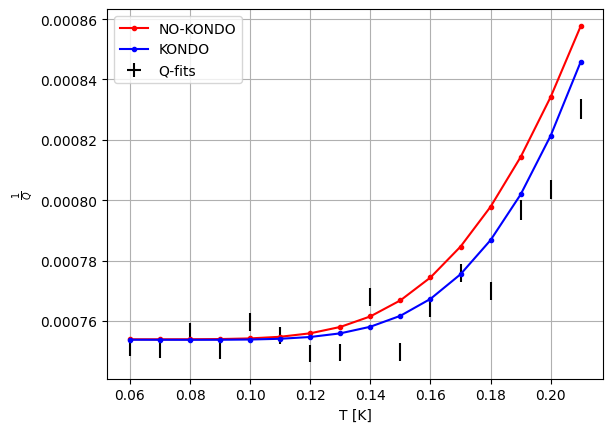

In [12]:
plt.errorbar(x, y, xerr=0, yerr=yerr, alpha=1, color='black', label='Q-fits', marker='.', fmt='none')
plt.plot(x, QT(x, d0), color='red', label='NO-KONDO', marker='.')
plt.plot(x, kondo(x, d0, b, T_k),  color='blue', label='KONDO', marker='.')
plt.xlabel('T [K]')
plt.ylabel(r'$\frac{1}{Q}$')
plt.legend()
plt.grid()

Now we can start to fit

In [13]:
#bounds = ([4.7*1e-23,4.7*1e-7,0.03],[4.75*1e-23,4.9*1e-7,0.5])
popt_nk,pcov_nk = curve_fit(QT, x, y, p0=[d0],sigma=yerr,maxfev=10000)
popt,pcov = curve_fit(kondo, x, y, p0=[d0,4.8e-7,0.035],sigma=yerr,maxfev=10000)#,bounds=bounds)

/var/folders/7c/2hlrxn717_x3q403mjghw0_m0000gn/T/ipykernel_7658/1494628343.py:13: RuntimeWarning: invalid value encountered in log
  return num/den * (alpha/2) + q0 - b*np.log(T/T_k)


In [14]:
chi2 = 0
chi2_nk = 0
for i in range(len(y)):
    chi2 += ((y[i]-kondo(T=x[i],d0=popt[0],b=popt[1],T_k=popt[2]))/yerr[i])**2
    chi2_nk += ((y[i]-QT(T=x[i],d0=popt_nk[0]))/yerr[i])**2
chi2_0 = chi2/(len(x)-3)
chi2_0_nk = chi2_nk/(len(x)-1)

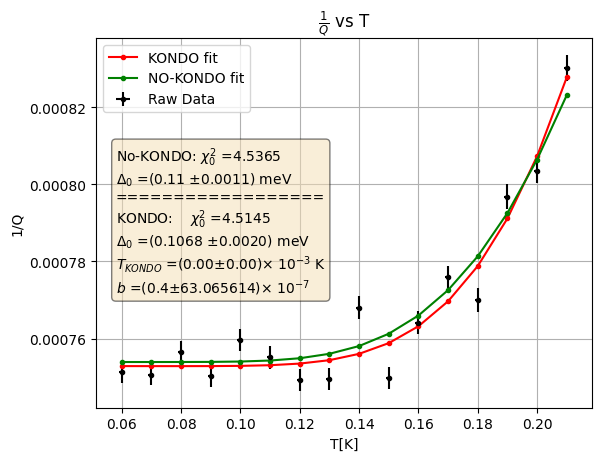

In [15]:
from matplotlib import lines as line
from matplotlib import colormaps as cmap
plt.errorbar(x,y, xerr=xerr, yerr=yerr,color='black',label='Raw Data',fmt='.')
plt.plot(x,kondo(x, *popt),marker='.',label='KONDO fit',color='red')#,label='KONDO-fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(x,QT(x,*popt_nk),marker='.',label='NO-KONDO fit', color='green')#,label='KONDO-fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.ylabel('1/Q')
plt.xlabel('T[K]')
textstr = '\n'.join((
    r"No-KONDO: $\chi_{0}^2$ ="+f"{chi2_0_nk:.4f}",
    r"$\Delta_{0}$ ="+f"({popt_nk[0]/c.electron_volt*1e3:.2f} "+r"$\pm$"+f"{np.sqrt(np.diag(pcov_nk)[0])/c.electron_volt*1e3:.4f})"+" meV",
    r"==================",
    r"KONDO:    $\chi_{0}^2$ ="+f"{chi2_0:.4f}",
    r"$\Delta_{0}$ ="+f"({popt[0]/c.electron_volt*1e3:.4f} "+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[0])/c.electron_volt*1e3:.4f})"+" meV",
    r"$T_{KONDO}$ ="+f"({popt[2]*1e3:.2f}"+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[2])*1e3:.2f})"+r"$\times$ $10^{-3}$"+" K",
    r"$b$ ="+f"({popt[1]*1e7:.1f}"+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[1])*1e7:.6f})"+r"$\times$ $10^{-7}$"
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.058, 0.000810, textstr, fontsize=10,verticalalignment='top', bbox=props)
plt.legend(loc='upper left')
plt.title(r'$\frac{1}{Q}$ vs T')
plt.grid()

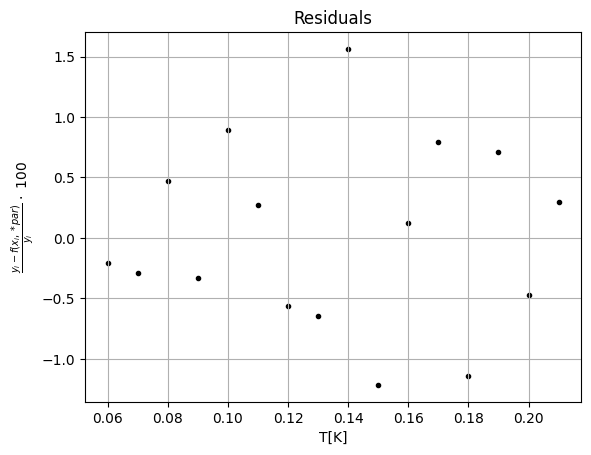

In [16]:
plt.scatter(x,(y-kondo(T=x,d0=popt[0],b=popt[1],T_k=popt[2]))/y * 100,marker='.',label='Residuals',color='black')
plt.xlabel('T[K]')
plt.title('Residuals')
plt.ylabel(r'$\frac{y_{i}-f(x_{i},*par)}{y_{i}}\cdot$ 100')
plt.grid()

In [17]:
T_c = 2*popt[0]/(3.5*c.Boltzmann)
Terr = (2*np.sqrt(np.diag(pcov)[0]))/(3.5*c.Boltzmann)
print('T_c '+f"{T_c:.4f}" + " +/- "+f"{Terr:.4f}")
'''
import csv 
with open (r'F:\LabIV\QTLab2324\IRdetection\Notebooks\results.txt', 'w') as f:
    writer = csv.writer(f, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    temp = [popt[0], np.sqrt(np.diag(pcov)[0]), T_c, Terr]
    writer.writerow(temp)'''

T_c 0.7079 +/- 0.0134
